# Install Libraries

In [1]:
# !pip install pandas numpy matplotlib seaborn scikit-learn

# Import Libraries

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score


# Load the Required Datasets

In [3]:
# Load the data from CSV files
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transactions.csv")

In [4]:
customers_df.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [5]:
transactions_df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


# Data Preprocessing

In [6]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB


In [7]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB


In [8]:
customers_df.isna().sum()

CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64

In [9]:
transactions_df.isna().sum()

TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64

In [10]:
# Merge customer and transaction data
merged_df = pd.merge(transactions_df, customers_df, on='CustomerID', how='left')

In [11]:
merged_df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15


In [12]:
# Feature Engineering: Calculate total spend, transaction count, and average order value
customer_transaction_data = merged_df.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count'),
    avg_order_value=('TotalValue', 'mean')
).reset_index()

In [13]:
customer_transaction_data.head()

,CustomerID,total_spend,transaction_count,avg_order_value
0,C0001,3354.52,5,670.904
1,C0002,1862.74,4,465.685
2,C0003,2725.38,4,681.345
3,C0004,5354.88,8,669.360
4,C0005,2034.24,3,678.080


In [14]:
# Merge the profile information (Region, SignupDate) with the transaction features
customer_features = pd.merge(customers_df[['CustomerID', 'Region', 'SignupDate']], customer_transaction_data, on='CustomerID')

In [15]:
# Handle missing values (if any)
customer_features = customer_features.fillna(0)

In [16]:
# Feature scaling: Normalize the numerical columns
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[['total_spend', 'transaction_count', 'avg_order_value']])


In [17]:
# Show a preview of the processed data
customer_features_scaled = pd.DataFrame(scaled_features, columns=['total_spend', 'transaction_count', 'avg_order_value'])
customer_features_scaled['CustomerID'] = customer_features['CustomerID']
customer_features_scaled.head()

,total_spend,transaction_count,avg_order_value,CustomerID
0,-0.061701,-0.011458,-0.070263,C0001
1,-0.877744,-0.467494,-0.934933,C0002
2,-0.405857,-0.467494,-0.026271,C0003
3,1.032547,1.356650,-0.076769,C0004
4,-0.783929,-0.923530,-0.040028,C0005


# Clustering

In [18]:
# Apply KMeans clustering
from sklearn.cluster import KMeans

# Define the number of clusters
n_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
customer_features_scaled['cluster'] = kmeans.fit_predict(customer_features_scaled[['total_spend', 'transaction_count', 'avg_order_value']])

In [19]:
# Show a preview of the clustered data
customer_features_scaled.head()

,total_spend,transaction_count,avg_order_value,CustomerID,cluster
0,-0.061701,-0.011458,-0.070263,C0001,1
1,-0.877744,-0.467494,-0.934933,C0002,1
2,-0.405857,-0.467494,-0.026271,C0003,1
3,1.032547,1.356650,-0.076769,C0004,0
4,-0.783929,-0.923530,-0.040028,C0005,1


In [20]:
from sklearn.metrics import davies_bouldin_score

# Calculate the Davies-Bouldin Index for the clusters
db_index = davies_bouldin_score(customer_features_scaled[['total_spend', 'transaction_count', 'avg_order_value']], customer_features_scaled['cluster'])

print(f"DB Index: {db_index}")

DB Index: 0.9578205962311453


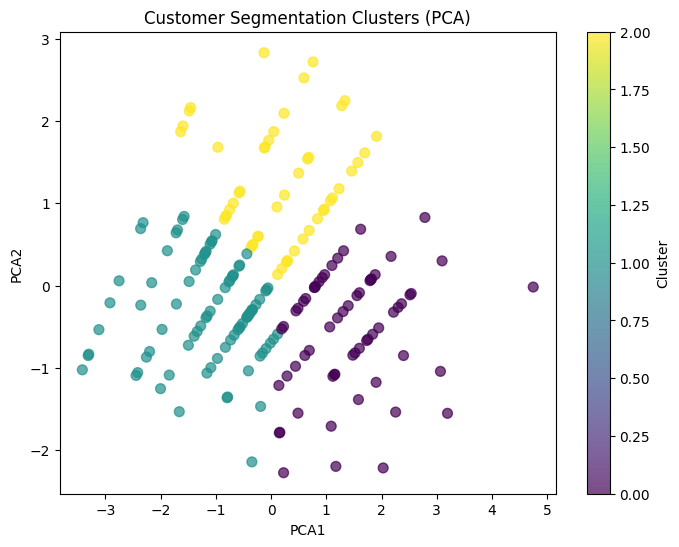

In [21]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)
pca_components = pca.fit_transform(customer_features_scaled[['total_spend', 'transaction_count', 'avg_order_value']])

# Create a DataFrame with the PCA components and cluster labels
pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = customer_features_scaled['cluster']

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['cluster'], cmap='viridis', s=50, alpha=0.7)
plt.title('Customer Segmentation Clusters (PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Cluster')
plt.show()

In [22]:
print("Inertia (Within-cluster sum of squares):", kmeans.inertia_)

Inertia (Within-cluster sum of squares): 247.1201125096421


In [23]:
# 1. Silhouette Score
from sklearn.metrics import silhouette_score

# Calculate silhouette score
sil_score = silhouette_score(customer_features_scaled[['total_spend', 'transaction_count', 'avg_order_value']], customer_features_scaled['cluster'])
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.36027262783851616


In [24]:
# 2. Cluster Size
cluster_sizes = customer_features_scaled['cluster'].value_counts()
print(f"Cluster Sizes:\n{cluster_sizes}")

Cluster Sizes:
cluster
1    86
0    63
2    50
Name: count, dtype: int64


In [25]:
# 3. Cluster Centers
cluster_centers = kmeans.cluster_centers_
print(f"Cluster Centers:\n{cluster_centers}")

Cluster Centers:
[[ 1.02548268  1.13948968  0.12557431]
 [-0.77973254 -0.4993106  -0.74354875]
 [ 0.0490318  -0.57694276  1.12068022]]


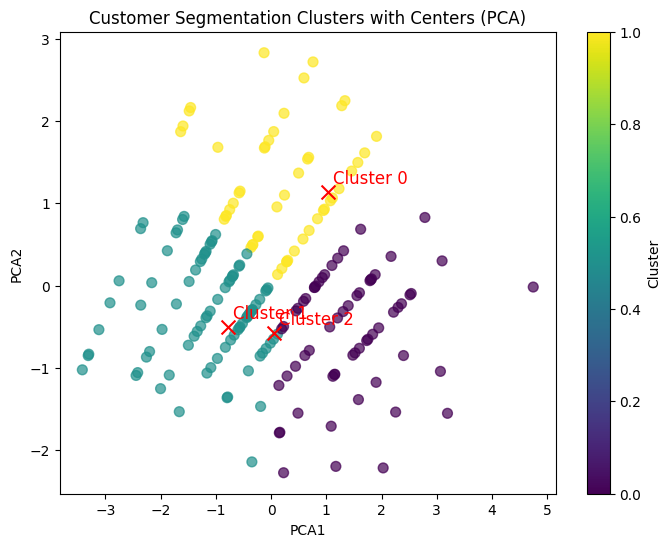

In [26]:
# Plot the cluster centers (add to PCA plot)
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['cluster'], cmap='viridis', s=50, alpha=0.7)

# Mark the cluster centers
for i, center in enumerate(cluster_centers):
    plt.scatter(center[0], center[1], marker='x', s=100, c='red')  # Plot center with a red 'x'
    plt.text(center[0] + 0.1, center[1] + 0.1, f'Cluster {i}', color='red', fontsize=12)

plt.title('Customer Segmentation Clusters with Centers (PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Cluster')
plt.show()

# Thank You!